In [1]:
import sys
print(sys.executable)

/home/mstryja/.conda/envs/stryja_sat/bin/python


In [2]:
import numpy as np
# Master lib:
from master_lib.utils import files_and_directories
from master_lib.image_processing.processing import dicom_to_array
from master_lib.loader.data_loader import evaluate_categories

# Rest
import pandas as pd
from master_lib.model.generator import DataGenerator
from typing import List

# model definition
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
from keras.layers import Input, Conv2D

# Preprocessing and additionals:
from sklearn.preprocessing import MinMaxScaler
from skimage import exposure
scaler = MinMaxScaler()

import cv2

import random

num_classes = 4

# matplotlib: 
import matplotlib.pyplot as plt

# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model_archive = '../trained_models/'

In [3]:
class Dataset:
    
    # CLASSES = ['Atypical Appearance', 'Indeterminate Appearance', 'Negative for Pneumonia', 'StudyInstanceUID', 'Typical Appearance', 'boxes', 'label']
    CLASSES = ['Atypical Appearance', 'Indeterminate Appearance', 'Negative for Pneumonia','Typical Appearance']
    def __init__(self, list_of_images, classes=None): #, """augmentation=None, preprocessing=None, resize=None, gray=None"""):
        self.images = list_of_images
        self.labels = [evaluate_categories(os.path.basename(img), cols=self.CLASSES) for img in self.images]
        
    def __getitem__(self, i):
        img = dicom_to_array(self.images[i])
        label = self.labels[i]
        
        return img, label
        
    def __len__(self):
        return len(self.images)
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=8, input_shape=(1024, 1024), preprocessing=None, shuffle=False, expanddims=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocessing = preprocessing
        self.input_shape = input_shape
        # self.patch_size = patch_size
        self.indexes = np.arange(len(dataset))
        self.expand = expanddims

        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            image, label = self.dataset[j][0], self.dataset[j][1]
            image = cv2.resize(image, self.input_shape, interpolation = cv2.INTER_AREA)
                
            if self.preprocessing=='HEqualization':
                # Histogram equalization
                # image, label = self.dataset[j][0], self.dataset[j][1]
                image = exposure.equalize_hist(image)
                # data.append([image, label])
            elif self.preprocessing=='MinMax':
                scaler.fit(image)
                image = scaler.transform(image)
                # data.append([image, label])
            else:
                # data.append([image, label])
                pass
            
            if self.expand:
                image = np.expand_dims(image, axis=-1)
        
            data.append([image, label])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        # print(batch.shape)
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

In [4]:
def dataset_partition(train_images_path_list: List, coef: float = 0.3, evaluation_cases: int = 150, verbose: int = 1):
    max_idx = len(train_images_path_list)-evaluation_cases
    up = int(np.ceil(max_idx*(1 - coef)))
    if verbose==1:
        o = f"dataset length: {len(train_images_path_list)}\nEvaluation Cases: {evaluation_cases}"
        o += f"\nTrain cases: {up}\nValidation cases: {max_idx - up}"
        print(o)
    return train_images_path_list[:up], train_images_path_list[up:max_idx], train_images_path_list[max_idx:]
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1)

filepath = r'C:\Users\MikołajStryja\Documents\Studia\master\model_checkpoints'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, 'model5_equalization_hist_checkpoints'), monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

def decode_label(labels, classes):
    for label, name in zip(labels, classes):
        if label==1:
            return name

In [5]:
dataset_path = '../dataset.json'
dataset = files_and_directories.load_json(dataset_path)
dataset_images = '../../../covid_dataset/'
dataset = files_and_directories.load_json(dataset_path)
train_imgs = files_and_directories.list_train_images(dataset_images)
Xtrain, Xval, Xeval = dataset_partition(train_imgs, coef=0.1)

dataset length: 6054
Evaluation Cases: 150
Train cases: 5314
Validation cases: 590


In [6]:
train_dataset = Dataset(Xtrain)
validation_dataset = Dataset(Xval)
test_dataset = Dataset(Xeval)

In [7]:
train_dataset.CLASSES

['Atypical Appearance',
 'Indeterminate Appearance',
 'Negative for Pneumonia',
 'Typical Appearance']

In [8]:
train_params = {
    'input_shape': (1024, 1024),
    'preprocessing': 'MinMax',
    'shuffle': True,
    'batch_size': 16,
    'epochs': 2
}

val_params = {
    'input_shape': (1024, 1024),
    'preprocessing': 'MinMax',
    'shuffle': False,
    'batch_size': 8
}

In [9]:
train_generator = Dataloder(train_dataset, 
                            input_shape=train_params['input_shape'],
                            batch_size=train_params['batch_size'], 
                            preprocessing=train_params['preprocessing'], 
                            shuffle=train_params['shuffle'],
                            expanddims=True
                           )
valid_generator = Dataloder(validation_dataset, 
                            input_shape=val_params['input_shape'],
                            batch_size=val_params['batch_size'], 
                            preprocessing=val_params['preprocessing'], 
                            shuffle=val_params['shuffle'],
                            expanddims=True)

In [10]:
train_generator[0][0][0].shape

(1024, 1024, 1)

1.0000000000000002 0.0
1.0 0.0
1.0000000000000002 0.0
1.0000000000000004 0.0
1.0000000000000002 0.0
1.0000000000000002 0.0
1.0000000000000004 0.0
1.0000000000000002 0.0


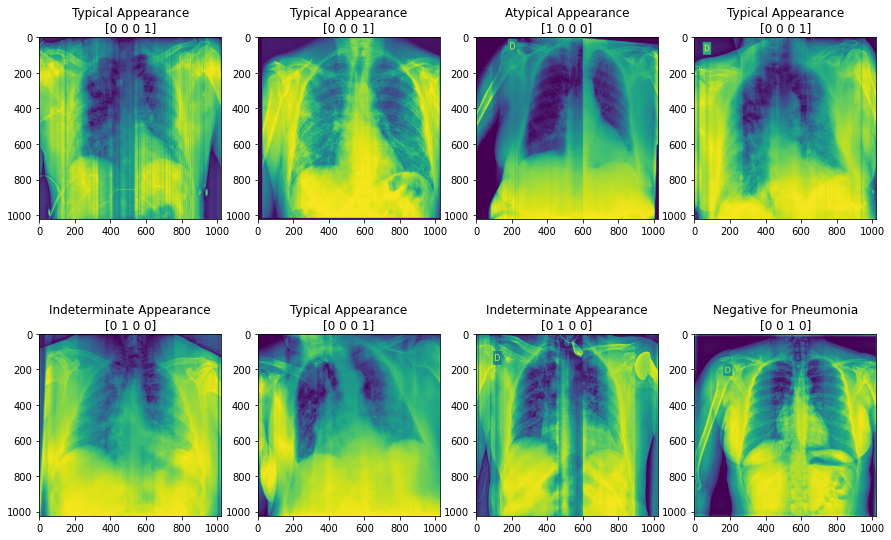

In [11]:
# Generator check:
ncols = 4
fig, axs = plt.subplots(2, ncols, figsize=(15,10))
row = col = 0
for i, (image, label) in enumerate(zip(train_generator[0][0][:ncols*2], train_generator[0][1][:ncols*2])):
    if i<ncols:
        title = decode_label(label, train_dataset.CLASSES)
        title += '\n' + str(label)
        axs[0, i].set_title(title, fontsize=12)
        axs[0, i].imshow(image)
        print(image.max(), image.min())
        
    else:
        title = decode_label(label, train_dataset.CLASSES)
        title += '\n' + str(label)
        axs[1, i-4].set_title(title, fontsize=12)
        axs[1, i-4].imshow(image)
        print(image.max(), image.min())

In [13]:
# Model definition
resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=4)

2022-01-20 12:45:02.705073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 12:45:03.800590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 192 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2022-01-20 12:45:03.805987: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 192.19M (201523200 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [31]:
resnet.output.shape[-1]

2048

In [17]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [15]:
inp = Input(shape=(*train_params['input_shape'], 1), name="Input")
converter = Conv2D(3, (1, 1), trainable=False, name='Converter')(inp) # map N channels data to 3 channels
x = resnet(converter)
x = keras.layers.GlobalAveragePooling2D(name="GLobAvaPooling2D")(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation =  tf.keras.activations.softmax
outputs = keras.layers.Dense(4,
                             kernel_initializer=initializer,
                             activation=activation, name='Output')(x) 

metrics = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), 
           keras.metrics.Precision(name="precision"), 
           keras.metrics.Recall(name="recall")]

model = keras.Model(inp, outputs, name="Resnet50")

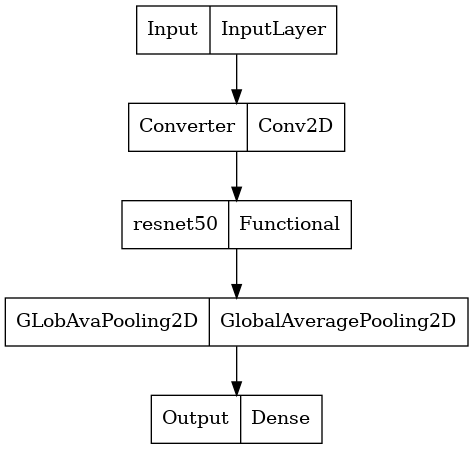

In [16]:
plot_model(model)

In [17]:
model.summary()

Model: "Resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1024, 1024, 1)]   0         
                                                                 
 Converter (Conv2D)          (None, 1024, 1024, 3)     6         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 GLobAvaPooling2D (GlobalAve  (None, 2048)             0         
 ragePooling2D)                                                  
                                                                 
 Output (Dense)              (None, 4)                 8196      
                                                                 
Total params: 23,595,914
Trainable params: 23,542,788
Non-trainable params: 53,126
_________________________________________

In [29]:
model.layers[2].output.shape

TensorShape([None, None, None, 2048])

In [2]:
model.compile(optimizer=optim,
              loss='hinge',# keras.losses.CategoricalCrossentropy(), # default from_logits=False
              metrics=metrics)

NameError: name 'model' is not defined

In [18]:
history = model.fit(train_generator, 
                    validation_data=valid_generator, 
                    epochs=train_params['epochs'])

Epoch 1/2


2022-01-17 15:40:19.252813: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-01-17 15:40:21.378643: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


124/332 [==========>...................] - ETA: 9:08 - loss: 1.0902 - categorical_accuracy: 0.5801 - precision: 0.6533 - recall: 0.4521

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


332/332 [==============================] - 1072s 3s/step - loss: 1.0656 - categorical_accuracy: 0.5889 - precision: 0.6712 - recall: 0.4539 - val_loss: 1.5243 - val_categorical_accuracy: 0.2637 - val_precision: 0.2637 - val_recall: 0.2637
Epoch 2/2
136/332 [===========>..................] - ETA: 9:38 - loss: 0.9230 - categorical_accuracy: 0.6471 - precision: 0.7359 - recall: 0.5404

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


332/332 [==============================] - 1073s 3s/step - loss: 0.9388 - categorical_accuracy: 0.6367 - precision: 0.7309 - recall: 0.5297 - val_loss: 1.2602 - val_categorical_accuracy: 0.4795 - val_precision: 0.1000 - val_recall: 0.0017


In [140]:
model.save(os.path.join(model_archive, 'ResNet50_FA_1'))

INFO:tensorflow:Assets written to: ../trained_models/ResNet50_FA_1/assets


INFO:tensorflow:Assets written to: ../trained_models/ResNet50_FA_1/assets
/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [79]:
test_datagenerator = Dataloder(test_dataset, batch_size=1, preprocessing='MinMax', shuffle=False, expanddims=True)
test_datagenerator[0][0][0].shape

(1024, 1024, 1)

In [80]:
scores = custom_model.evaluate(test_datagenerator)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.name, value))

150/150 [==============================] - 34s 225ms/step - loss: 0.5591 - categorical_accuracy: 0.2533 - precision: 0.2656 - recall: 0.2267
Loss: 0.55911
mean categorical_accuracy: 0.25333
mean precision: 0.26562
mean recall: 0.22667


[87, 96, 41, 29, 64, 66]
[[0. 0. 1. 0.]]
[[0. 0. 1. 0.]]
[[0. 0. 1. 0.]]
[[0. 0. 1. 0.]]
[[0. 0. 1. 0.]]
[[0. 0. 1. 0.]]


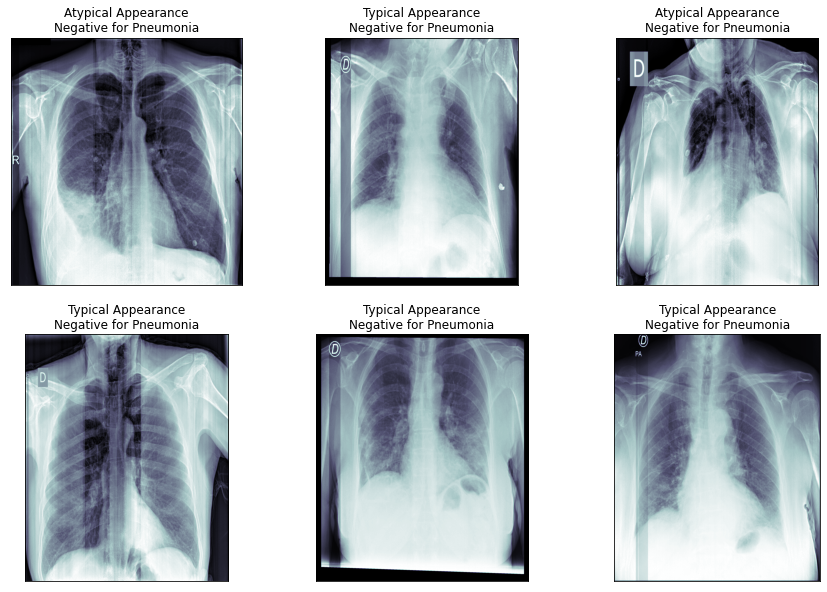

In [83]:
idxs = random.sample(range(0, len(test_dataset)), 6)
print(idxs)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

row = col = 0
for idx in idxs:
    if col==3:
        row += 1
        col = 0
    
    orig_shape = test_dataset[idx][0].shape
    # print(orig_shape)
    image, label = test_datagenerator[idx][0], test_datagenerator[idx][1]
    axs[row, col].imshow(cv2.resize(image[0], orig_shape, interpolation = cv2.INTER_AREA), cmap=plt.cm.bone)
    pred = custom_model.predict(image)
    # print(pred)
    pred = pred.round()
    print(pred)
    title = decode_label(label[0], test_dataset.CLASSES) + '\n' + decode_label(pred[0], test_dataset.CLASSES)
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xticks([])
    axs[row, col].set_yticks([])
    col+=1

In [64]:
class CovidClassifier(keras.Model):
    def __init__(self, n_classes=4, **params):
        super(CovidClassifier, self).__init__()
        # self.input_shape = input_shape
        # self.model_input = Input(shape=(None, *input_shape, 1), name="input")
        self.converter = Conv2D(3, (1, 1), trainable=False, name='Converter')
        self.resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
                               input_shape=None, pooling=None, classes=n_classes)
        self.glob_ava_pooling_2d = keras.layers.GlobalAveragePooling2D(name="GLobAvaPooling2D")
        self.initializer = tf.keras.initializers.GlorotUniform(seed=42)
        self.activation =  tf.keras.activations.softmax
        
        self.dense_shapes = self.calculate_depth()
        self.sequentional_block = tf.keras.Sequential()
        for s in self.dense_shapes:
            self.sequentional_block.add(keras.layers.Dense(s, activation='relu'))
            
        
        self.outputs = keras.layers.Dense(4,
                                          kernel_initializer=self.initializer,
                                          activation=self.activation)
        
        
        
        
    def call(self, inputs):
        # x = Input(shape=(*inputs.shape[1:], 1), name="input")
        x = self.converter(inputs)
        x = self.resnet(x)
        x = self.glob_ava_pooling_2d(x)
        x = self.sequentional_block(x)
        return self.outputs(x)  
    
    def get_config(self):
        config = super(CovidClassifier, self).get_config()
        
    def calculate_depth(self):
        out_shape = self.resnet.output.shape[-1]
        shapes = []
        while out_shape > 4*2:
            out_shape /= 2
            shapes.append(int(out_shape))
            print(out_shape)
        return shapes
            
        

In [65]:
custom_model = CovidClassifier((train_params['input_shape']))

1024.0
512.0
256.0
128.0
64.0
32.0
16.0
8.0


In [66]:
metrics = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None), 
                        keras.metrics.Precision(name="precision"), 
                        keras.metrics.Recall(name="recall")]

custom_model.compile(optimizer=optim,
                     loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
                     metrics=metrics)

In [67]:
custom_model.dense_shapes

ListWrapper([1024, 512, 256, 128, 64, 32, 16, 8])

In [68]:
custom_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [69]:
history_custom = custom_model.fit(train_generator,
                                  validation_data=valid_generator, 
                                  epochs=1)#train_params['epochs'])

216/332 [==================>...........] - ETA: 6:18 - loss: 0.6170 - categorical_accuracy: 0.5602 - precision: 0.6581 - recall: 0.3113

/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:359: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


332/332 [==============================] - 1226s 4s/step - loss: 0.5594 - categorical_accuracy: 0.5729 - precision: 0.6566 - recall: 0.3784 - val_loss: 0.5525 - val_categorical_accuracy: 0.2637 - val_precision: 0.2722 - val_recall: 0.2312


In [224]:
custom_model.save(os.path.join(model_archive, custom_model.name))

INFO:tensorflow:Assets written to: ../trained_models/covid_classifier_29/assets


INFO:tensorflow:Assets written to: ../trained_models/covid_classifier_29/assets
/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/mstryja/.conda/envs/stryja_sat/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [190]:
A = np.expand_dims(A, axis=-1)

In [191]:
A.shape

(2, 3, 1)

In [192]:
A

array([[[1],
        [2],
        [3]],

       [[1],
        [2],
        [3]]])